In [1]:
import os
import pathlib
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
"""
# Mount the remote storage with the dataset
from google.colab import drive
drive.mount('/content/drive')
os.system("unzip -q drive/MyDrive/msa/CatsDogs.zip")
"""

'\n# Mount the remote storage with the dataset\nfrom google.colab import drive\ndrive.mount(\'/content/drive\')\nos.system("unzip -q drive/MyDrive/msa/CatsDogs.zip")\n'

# The first architecture

In [3]:
# Define the directory of the dataset
data_dir = pathlib.Path('CatsDogs/')

# Remove corrupted files
os.system("rm CatsDogs/Cats/666.jpg CatsDogs/Dogs/11702.jpg CatsDogs/Dogs/11410.jpg")

# Collects the path of all the files within the dataset
data_paths = [str(path) for path in list(data_dir.glob("*/*.jpg"))]
print(f"Images in the dataset: {len(data_paths)}")

Images in the dataset: 24997


rm: CatsDogs/Cats/666.jpg: No such file or directory
rm: CatsDogs/Dogs/11702.jpg: No such file or directory
rm: CatsDogs/Dogs/11410.jpg: No such file or directory


In [4]:
# Convert non-jpeg images into jpeg files
formats = [(path, Image.open(path).format) for path in data_paths]
non_jpegs = list(filter(lambda x: x[1]!='JPEG', formats))
for path, _ in non_jpegs:
    img = Image.open(path)
    img.convert('RGB').save(path, format='JPEG')

/Users/filippouslenghi/miniconda3/envs/audio2/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [5]:
# Create the respective tf.data.Dataset object
dataset = tf.data.Dataset.from_tensor_slices(data_paths)
# Shuffle the dataset
dataset = dataset.shuffle(len(data_paths))

Metal device set to: Apple M1 Pro


2022-07-11 18:15:27.879310: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-11 18:15:27.879415: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
# Get the class names
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name[0] != '.']))
print(class_names)

['Cats' 'Dogs']


In [7]:
# Create a test set
test_size = int(len(list(dataset)) * 0.2)
train = dataset.skip(test_size)
test = dataset.take(test_size)

# Create a validation set
val_size = int(len(list(train)) * 0.2)
train = train.skip(val_size)
val = train.take(val_size)

In [8]:
# Set initial params for the loader
batch_size = 64
img_height = 150
img_width = 150

In [9]:
def get_label(file_path):
    # Convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    # Integer encode the label
    return tf.argmax(one_hot)

In [10]:
def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])

In [11]:
def process_path(file_path):
    label = get_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [12]:
# Create a dataset of image, label pairs
train = train.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val = val.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
test = test.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

In [13]:
# Configure dataset for performance
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

train = configure_for_performance(train)
val = configure_for_performance(val)
test = configure_for_performance(test)

In [14]:
num_classes = 1

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(8, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='sigmoid')
])

In [15]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

In [16]:
n_epochs = 15

history = model.fit(
    train,
    validation_data=val,
    epochs=n_epochs
)

Epoch 1/15


2022-07-11 18:15:29.246854: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-11 18:15:29.247015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 83/250 [========>.....................] - ETA: 5s - loss: 0.7458 - accuracy: 0.5299

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


173/250 [===================>..........] - ETA: 2s - loss: 0.6948 - accuracy: 0.5837

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


227/250 [==========================>...] - ETA: 0s - loss: 0.6745 - accuracy: 0.6036

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


235/250 [===========================>..] - ETA: 0s - loss: 0.6719 - accuracy: 0.6065

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


250/250 [==============================] - ETA: 0s - loss: 0.6673 - accuracy: 0.6119

2022-07-11 18:15:38.088744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


250/250 [==============================] - 10s 38ms/step - loss: 0.6673 - accuracy: 0.6119 - val_loss: 0.5843 - val_accuracy: 0.6769
Epoch 2/15
250/250 [==============================] - 8s 32ms/step - loss: 0.5571 - accuracy: 0.7168 - val_loss: 0.5450 - val_accuracy: 0.7189
Epoch 3/15
250/250 [==============================] - 8s 32ms/step - loss: 0.5155 - accuracy: 0.7470 - val_loss: 0.4817 - val_accuracy: 0.7697
Epoch 4/15
250/250 [==============================] - 8s 32ms/step - loss: 0.4856 - accuracy: 0.7677 - val_loss: 0.4480 - val_accuracy: 0.7904
Epoch 5/15
250/250 [==============================] - 8s 32ms/step - loss: 0.4577 - accuracy: 0.7827 - val_loss: 0.4334 - val_accuracy: 0.8065
Epoch 6/15
250/250 [==============================] - 8s 32ms/step - loss: 0.4298 - accuracy: 0.7999 - val_loss: 0.4228 - val_accuracy: 0.7964
Epoch 7/15
250/250 [==============================] - 8s 32ms/step - loss: 0.4067 - accuracy: 0.8126 - val_loss: 0.3997 - val_accuracy: 0.8172
Epoch 8/1

In [17]:
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

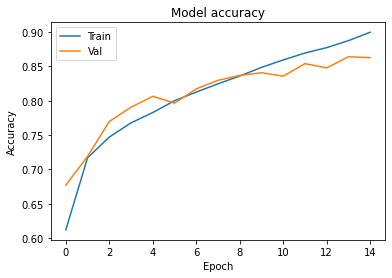

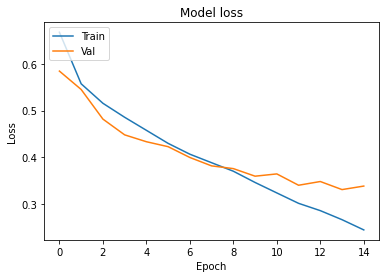

In [18]:
plot_history(history)

In [19]:
model.evaluate(test)

79/79 [==============================] - 3s 27ms/step - loss: 0.3628 - accuracy: 0.8580


[0.3627971112728119, 0.8579716086387634]

In [20]:
def zero_one_loss(dataset):

    missmatches = 0
    for i, (data, labels) in enumerate(dataset.as_numpy_iterator()):

        y_pred_binary = np.around(model.predict(x=np.asarray(data), verbose=0)).flatten()
        missmatches += np.sum(np.logical_xor(y_pred_binary, labels))


    return missmatches

In [21]:
print(f"Zero-one loss on the test set: {zero_one_loss(test)}")

2022-07-11 18:17:34.840763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Zero-one loss on the test set: 710


2022-07-11 18:17:38.067277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 20736)             0

# K-fold cross validation

In [20]:
from random import shuffle
from sklearn.model_selection import KFold


shuffle(data_paths)
k_fold = KFold(n_splits=5)
k_splits = k_fold.split(data_paths)
results = []
zero_one_losses = []

for train_index, test_index in k_splits:

    # Clear any previous state
    del model
    tf.keras.backend.clear_session()

    # Get the paths to the data
    train_paths = np.asarray(data_paths)[train_index]
    test_paths = np.asarray(data_paths)[test_index]

    # Make it tf.data.Dataset
    train = tf.data.Dataset.from_tensor_slices(train_paths)
    test = tf.data.Dataset.from_tensor_slices(test_paths)
    
    # Get labels
    train = train.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    test = test.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Configure for performance
    train = configure_for_performance(train)
    test = configure_for_performance(test)

    # Create the model
    num_classes = 1
    model = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='sigmoid')
    ])

    model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

    model.fit(
        train,
        epochs=n_epochs,
        verbose=0
    )

    results.append(model.evaluate(test))
    zero_one_losses.append(zero_one_loss(test))

2022-07-09 16:20:53.238648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
2022-07-09 16:23:27.836037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/79 [========>.....................] - ETA: 2s - loss: 0.6192 - accuracy: 0.8194

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


37/79 [=============>................] - ETA: 1s - loss: 0.6336 - accuracy: 0.8176

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


51/79 [==================>...........] - ETA: 0s - loss: 0.6151 - accuracy: 0.8214

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/79 [======================>.......] - ETA: 0s - loss: 0.6188 - accuracy: 0.8211

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


79/79 [==============================] - 3s 28ms/step - loss: 0.6083 - accuracy: 0.8222


2022-07-09 16:23:30.462786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-09 16:23:33.940737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-09 16:23:35.385373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Cor

79/79 [==============================] - 2s 26ms/step - loss: 0.7695 - accuracy: 0.8148


2022-07-09 16:26:13.833455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-09 16:26:17.329504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-09 16:26:19.069567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corr

24/79 [========>.....................] - ETA: 1s - loss: 0.7194 - accuracy: 0.8444

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


79/79 [==============================] - 3s 25ms/step - loss: 0.7747 - accuracy: 0.8228


2022-07-09 16:28:54.482377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-09 16:28:58.265283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-09 16:28:59.884515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
20

13/79 [===>..........................] - ETA: 1s - loss: 0.6527 - accuracy: 0.8197

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


25/79 [========>.....................] - ETA: 1s - loss: 0.6289 - accuracy: 0.8212

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


79/79 [==============================] - 2s 25ms/step - loss: 0.6343 - accuracy: 0.8236


2022-07-09 16:31:35.934742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-09 16:31:39.342243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-09 16:31:40.703415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Cor

37/79 [=============>................] - ETA: 1s - loss: 0.9591 - accuracy: 0.7977

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


55/79 [===================>..........] - ETA: 0s - loss: 0.9673 - accuracy: 0.7952

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


79/79 [==============================] - 3s 32ms/step - loss: 0.9914 - accuracy: 0.7932


2022-07-09 16:34:15.953454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-09 16:34:19.446655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [21]:
mean_loss = np.mean(zero_one_losses)
mean_accuracy = np.mean([result[1] for result in results])
print(f'Mean zero-one loss: {mean_loss}, mean accuracy: {np.round(mean_accuracy, decimals=4)}')

Mean zero-one loss: 923.4, mean accuracy: 0.8153


# Nested K-fold cross validation

In [ ]:
def prepare_data(data, train_index, test_index):
    # Get the paths to the data
    train_paths = np.asarray(data)[train_index]
    test_paths = np.asarray(data)[test_index]

    # Make it tf.data.Dataset
    train = tf.data.Dataset.from_tensor_slices(train_paths)
    test = tf.data.Dataset.from_tensor_slices(test_paths)

    # Get labels
    train = train.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    test = test.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

    # Configure for performance
    train = configure_for_performance(train)
    test = configure_for_performance(test)

    return train, test

In [ ]:
def build_and_run_model(architecture, **kwargs):

    n_epochs = n_epochs
    batch_size = batch_size
    activation = activation

    # Build
    num_classes = 1
    model = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(32, 3, activation=activation),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, activation=activation),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, activation=activation),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=activation),
        tf.keras.layers.Dense(num_classes, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy'])

    # Run
    model.fit(
        train,
        epochs=n_epochs,
        verbose=0
    )

In [61]:
def k_fold_cross_validation(n_folds, architecture, params):

    shuffle(data_paths)
    k_fold = KFold(n_splits=n_folds)
    k_splits = k_fold.split(data_paths)

    results = []
    zero_one_losses = []
    for train_index, test_index in k_splits:

        # Clear any previous state
        del model
        tf.keras.backend.clear_session()

        # Prepare the dataset
        prepare_data(data_paths, train_index, test_index)

        # Build and run the model
        build_and_run_model(architecture, **params)


        results.append(model.evaluate(test))
        zero_one_losses.append(zero_one_loss(test))

In [ ]:
for architecture in architectures:
    for activation in activations:
        for batch_size in batch_sizes:
            for n_epochs in epochs:
                params = {'activation': activation, 'batch_size': batch_size, 'n_epochs': n_epochs}
                k_fold_cross_validation(n_folds=5, architecture, params)